# Analysing NYC Open Data 🗽🌇

First step, as always, import the necessary packages:

In [39]:
library(tidyverse)

theme_set(theme_bw())

options(repr.plot.width=10, repr.plot.height=5)

Next, reading in the data:

In [40]:
data <- read_csv("C:/Users/mathi/Downloads/NYC Arrests/NYPD_Arrests_Data__Historic_.csv") %>% 
    mutate(ARREST_DATE = lubridate::mdy(ARREST_DATE))

Rows: 5308876 Columns: 19
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): ARREST_DATE, PD_DESC, OFNS_DESC, LAW_CODE, LAW_CAT_CD, ARREST_BORO...
dbl  (9): ARREST_KEY, PD_CD, KY_CD, ARREST_PRECINCT, JURISDICTION_CODE, X_CO...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [41]:
glimpse(data)

Rows: 5,308,876
Columns: 19
$ ARREST_KEY        <dbl> 236791704, 237354740, 236081433, 32311380, 192799737…
$ ARREST_DATE       <date> 2021-11-22, 2021-12-04, 2021-11-09, 2007-06-18, 201…
$ PD_CD             <dbl> 581, 153, 681, 511, 177, NA, 579, 263, 729, 153, 101…
$ PD_DESC           <chr> NA, "RAPE 3", "CHILD, ENDANGERING WELFARE", "CONTROL…
$ KY_CD             <dbl> NA, 104, 233, 235, 116, NA, NA, 114, 113, 104, 344, …
$ OFNS_DESC         <chr> NA, "RAPE", "SEX CRIMES", "DANGEROUS DRUGS", "SEX CR…
$ LAW_CODE          <chr> "PL 2225001", "PL 1302502", "PL 2601001", "PL 220030…
$ LAW_CAT_CD        <chr> "M", "F", "M", "M", "F", "F", "F", "F", "F", "F", "M…
$ ARREST_BORO       <chr> "M", "B", "Q", "Q", "M", "M", "Q", "B", "Q", "K", "K…
$ ARREST_PRECINCT   <dbl> 28, 41, 113, 27, 25, 14, 115, 41, 113, 67, 83, 23, 3…
$ JURISDICTION_CODE <dbl> 0, 0, 0, 1, 0, 0, 0, 72, 0, 0, 0, 0, 0, 0, 2, 0, 0, …
$ AGE_GROUP         <chr> "45-64", "25-44", "25-44", "18-24", "45-64", "25-44"…
$ PERP_SEX  

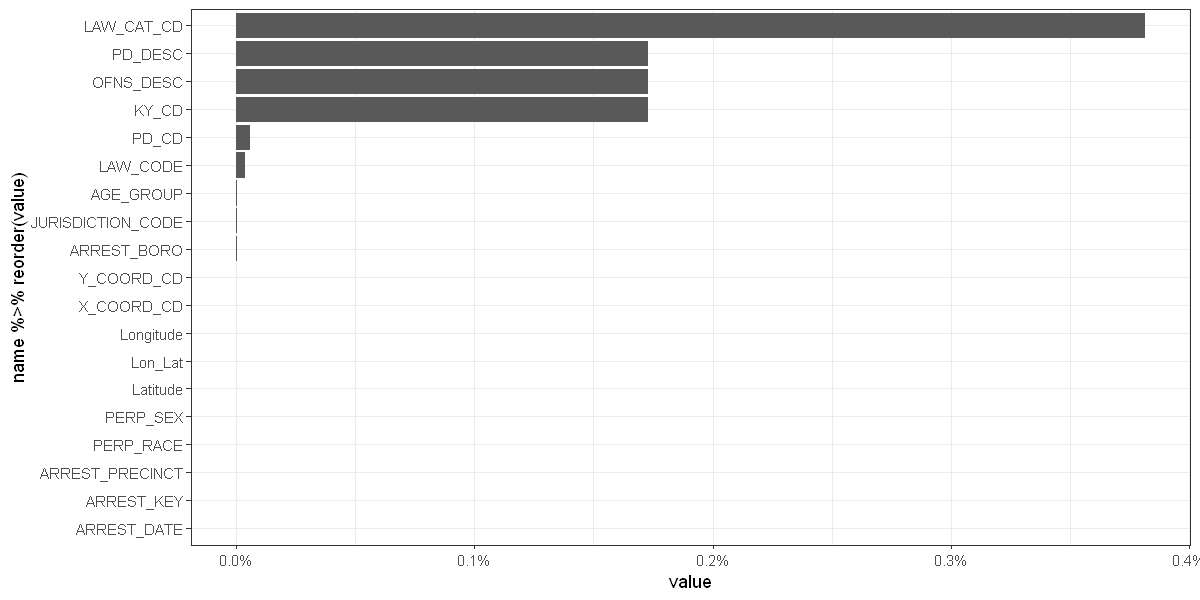

In [42]:
colMeans(is.na(data)) %>% 
    enframe() %>% 
    ggplot(aes(y = name %>% reorder(value), value)) + 
    geom_col() +
    scale_x_continuous(labels = scales::percent_format())

Almost no missing values, which is great!

### Number of arrests by year, by month in year, by week in year and by day of week

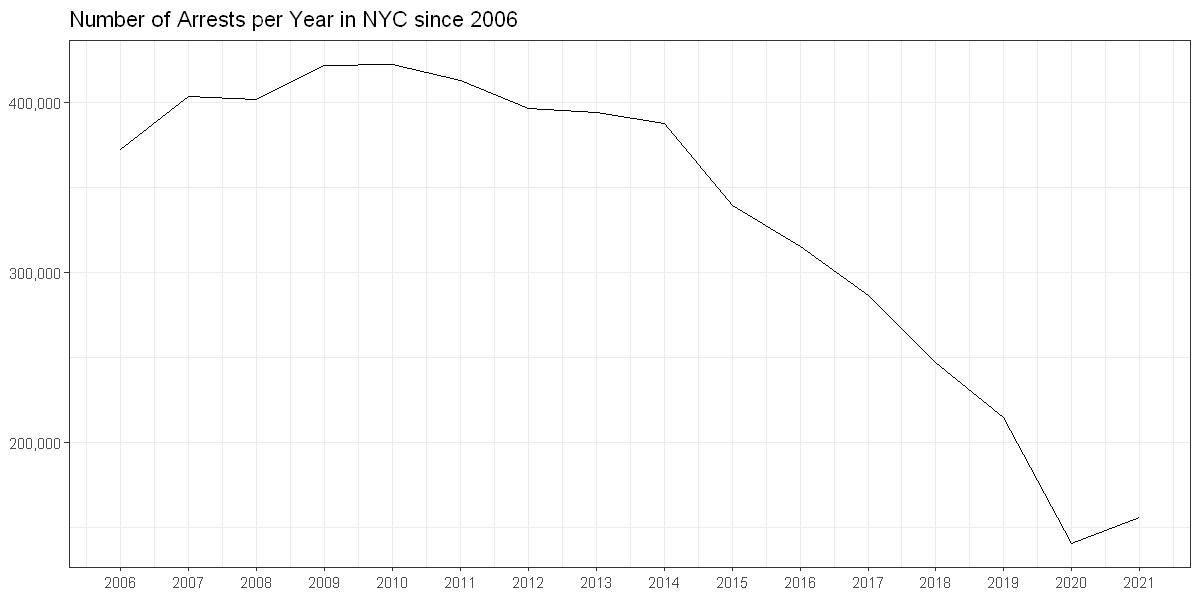

In [43]:
data %>%
    mutate(
        year = lubridate::year(ARREST_DATE),
        month = lubridate::month(ARREST_DATE),
        week_of_year = lubridate::week(ARREST_DATE),
        doy = lubridate::yday(ARREST_DATE)
    ) %>%
    count(year) %>%
    ggplot(aes(year, n)) +
    geom_line() +
    labs(
        title = "Number of Arrests per Year in NYC since 2006",
        y = NULL, x = NULL
    ) +
    scale_y_continuous(labels = scales::comma_format()) +
    scale_x_continuous(breaks = 2006:2021)

Arrests have dramatically gone down... Due to fewer crimes or due to fewer arrests made by the police? Or change in legislation?

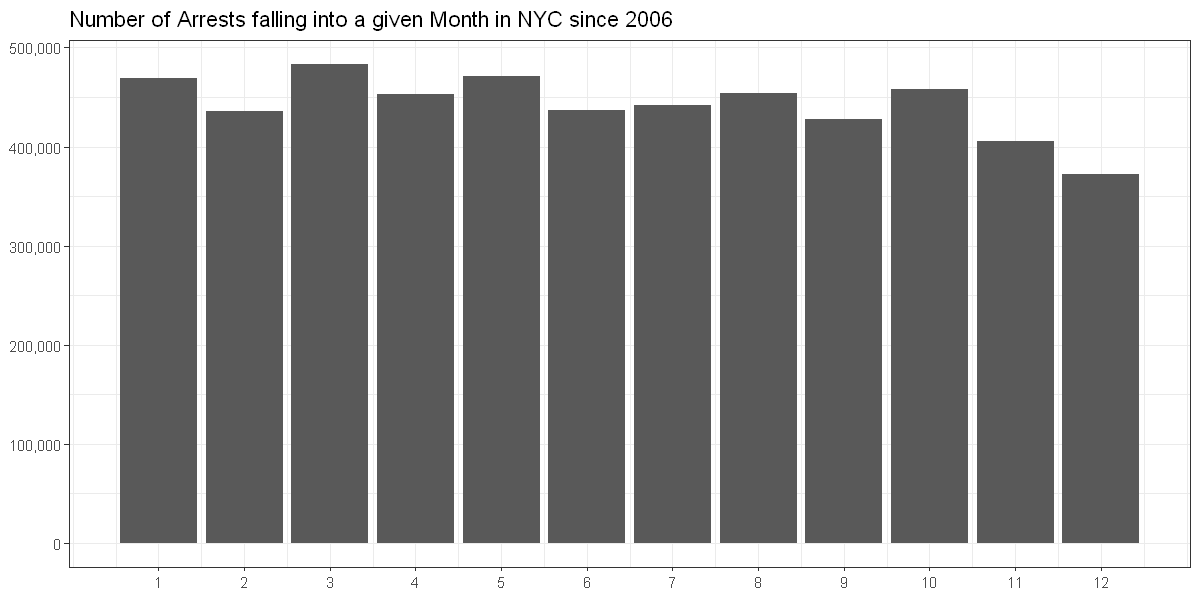

In [44]:
data %>%
    mutate(
        year = lubridate::year(ARREST_DATE),
        month = lubridate::month(ARREST_DATE),
        week_of_year = lubridate::week(ARREST_DATE),
        doy = lubridate::yday(ARREST_DATE)
    ) %>%
    count(month) %>% 
    ggplot(aes(month, n)) +
    geom_col() +
    labs(
        title = "Number of Arrests falling into a given Month in NYC since 2006",
        y = NULL, x = NULL
    ) +
    scale_y_continuous(labels = scales::comma_format()) +
    scale_x_continuous(breaks = 1:12)

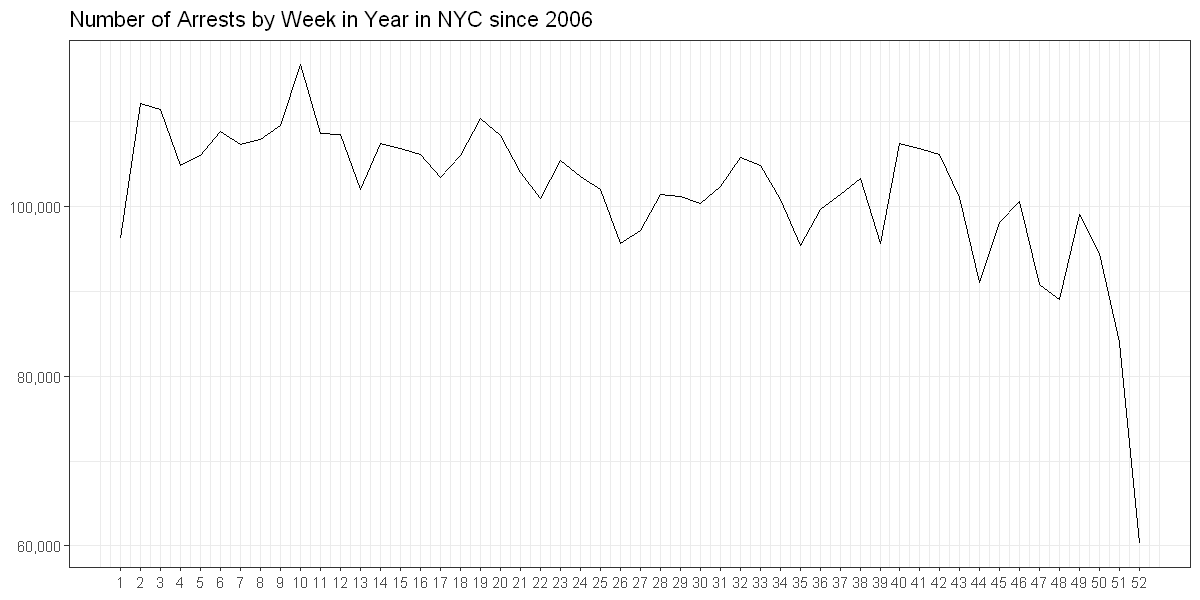

In [45]:
data %>%
    mutate(
        year = lubridate::year(ARREST_DATE),
        month = lubridate::month(ARREST_DATE),
        week_of_year = lubridate::week(ARREST_DATE),
        doy = lubridate::yday(ARREST_DATE)
    ) %>%
    filter(week_of_year <= 52) %>% 
    count(week_of_year) %>% 
    ggplot(aes(week_of_year, n)) +
    geom_line() +
    labs(
        title = "Number of Arrests by Week in Year in NYC since 2006",
        y = NULL, x = NULL
    ) +
    scale_y_continuous(labels = scales::comma_format()) +
    scale_x_continuous(breaks = 1:52)

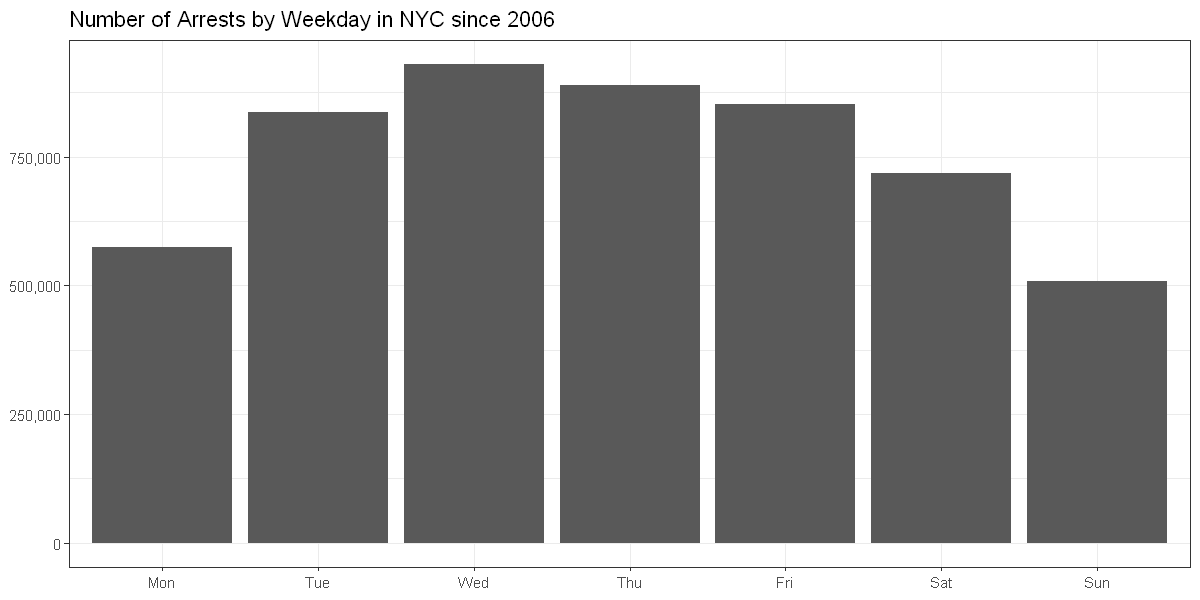

In [46]:
data %>%
    mutate(
        year = lubridate::year(ARREST_DATE),
        month = lubridate::month(ARREST_DATE),
        week_of_year = lubridate::week(ARREST_DATE),
        doy = lubridate::wday(ARREST_DATE, label = TRUE, week_start = 1)
    ) %>%
    count(doy)  %>% 
    ggplot(aes(doy, n)) +
    geom_col() +
    labs(
        title = "Number of Arrests by Weekday in NYC since 2006",
        y = NULL, x = NULL
    ) +
    scale_y_continuous(labels = scales::comma_format())

### Which demographies are responsible for which gravity of offenses and for which offenses in particular?

In [47]:
glimpse(data)

Rows: 5,308,876
Columns: 19
$ ARREST_KEY        <dbl> 236791704, 237354740, 236081433, 32311380, 192799737…
$ ARREST_DATE       <date> 2021-11-22, 2021-12-04, 2021-11-09, 2007-06-18, 201…
$ PD_CD             <dbl> 581, 153, 681, 511, 177, NA, 579, 263, 729, 153, 101…
$ PD_DESC           <chr> NA, "RAPE 3", "CHILD, ENDANGERING WELFARE", "CONTROL…
$ KY_CD             <dbl> NA, 104, 233, 235, 116, NA, NA, 114, 113, 104, 344, …
$ OFNS_DESC         <chr> NA, "RAPE", "SEX CRIMES", "DANGEROUS DRUGS", "SEX CR…
$ LAW_CODE          <chr> "PL 2225001", "PL 1302502", "PL 2601001", "PL 220030…
$ LAW_CAT_CD        <chr> "M", "F", "M", "M", "F", "F", "F", "F", "F", "F", "M…
$ ARREST_BORO       <chr> "M", "B", "Q", "Q", "M", "M", "Q", "B", "Q", "K", "K…
$ ARREST_PRECINCT   <dbl> 28, 41, 113, 27, 25, 14, 115, 41, 113, 67, 83, 23, 3…
$ JURISDICTION_CODE <dbl> 0, 0, 0, 1, 0, 0, 0, 72, 0, 0, 0, 0, 0, 0, 2, 0, 0, …
$ AGE_GROUP         <chr> "45-64", "25-44", "25-44", "18-24", "45-64", "25-44"…
$ PERP_SEX  

In [48]:
data %>%
    count(PERP_SEX) %>% 
    mutate(pct = n/sum(n))

PERP_SEX,n,pct
<chr>,<int>,<dbl>
F,891469,0.1679205
M,4417407,0.8320795


Men make up a shocking >83% of arrests.

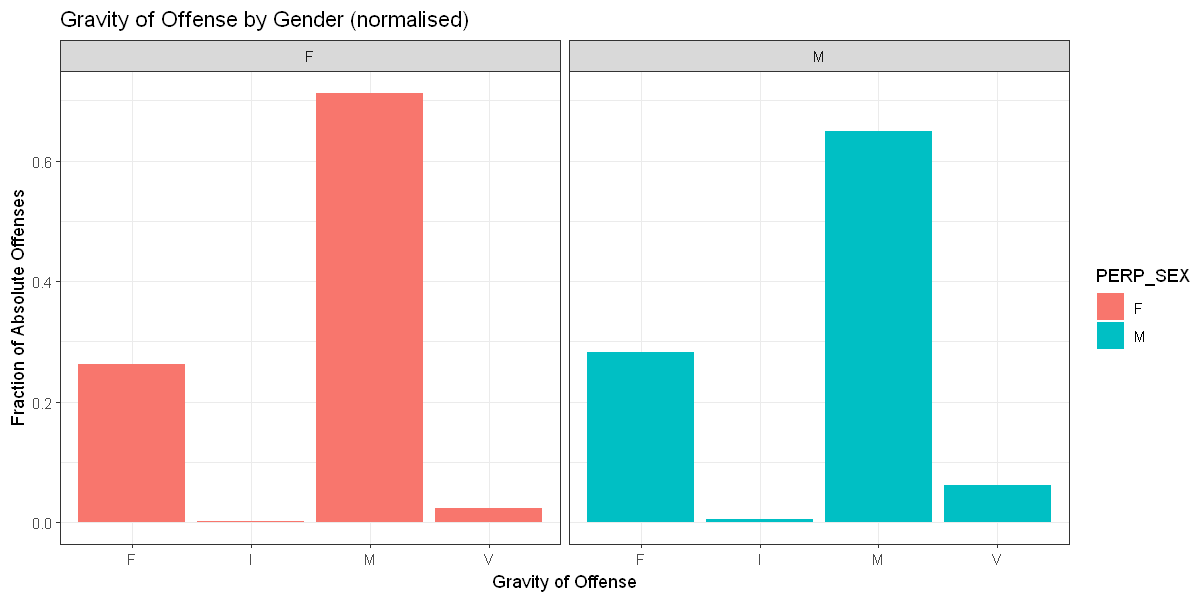

In [49]:
data %>%
    drop_na(LAW_CAT_CD, PERP_SEX) %>%
    count(LAW_CAT_CD, PERP_SEX) %>%
    group_by(PERP_SEX) %>%
    mutate(n = n / sum(n)) %>%
    ggplot(aes(
        x = LAW_CAT_CD,
        y = n,
        fill = PERP_SEX
    )) +
    geom_col() +
    labs(
        title = "Gravity of Offense by Gender (normalised)",
        y = "Fraction of Absolute Offenses",
        x = "Gravity of Offense"
    ) +
    facet_wrap(~PERP_SEX) +
    scale_y_continuous(labels = scales::comma_format())

Number of arrests by race over time (relative terms):

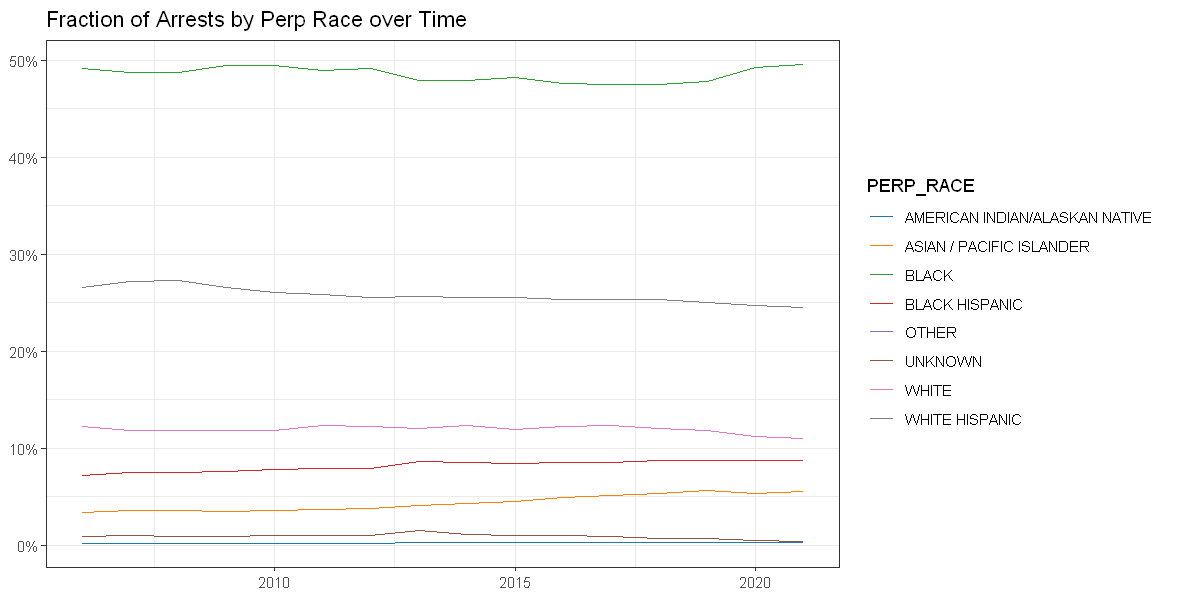

In [50]:
data %>%
    mutate(year = lubridate::year(ARREST_DATE)) %>%
    count(year, PERP_RACE) %>%
    drop_na() %>%
    group_by(year) %>%
    mutate(n = n / sum(n)) %>%
    ungroup() %>%
    ggplot(aes(year, n, colour = PERP_RACE)) +
    geom_line() +
    labs(
        title = "Fraction of Arrests by Perp Race over Time",
        y = NULL, x = NULL
    ) +
    ggsci::scale_colour_d3() +
    scale_y_continuous(labels = scales::percent_format())

Relative number of arrests by borough over time:

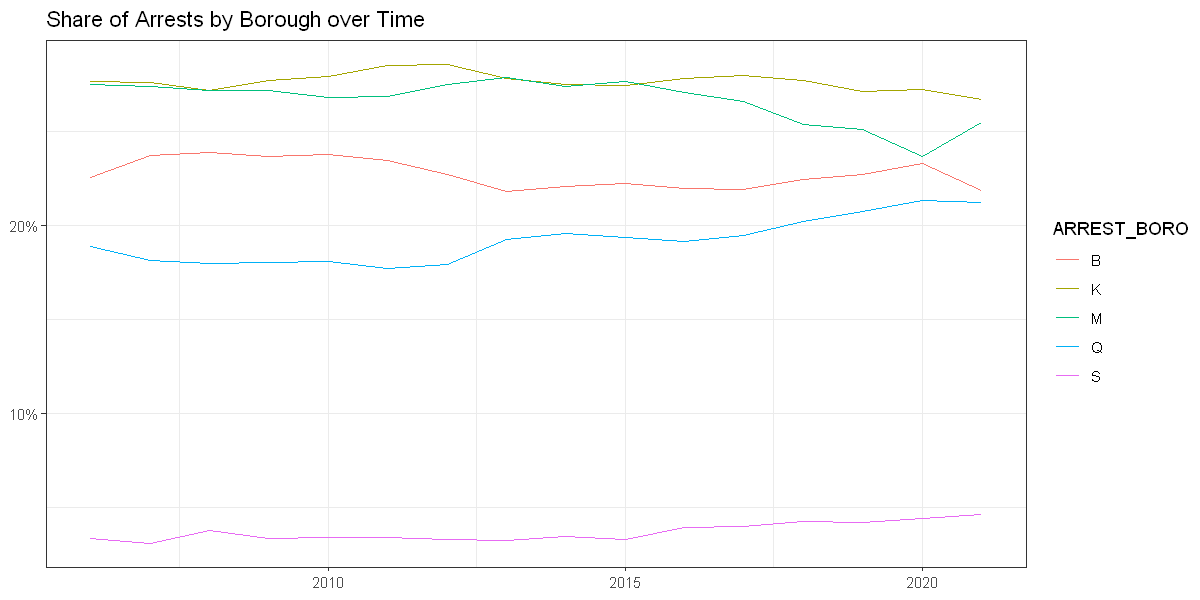

In [51]:
data %>% 
    mutate(year = lubridate::year(ARREST_DATE)) %>% 
    count(ARREST_BORO, year) %>% 
    drop_na() %>% 
    group_by(year) %>% 
    mutate(n = n/sum(n)) %>% 
    ggplot(aes(year, n, colour = ARREST_BORO)) +
    labs(title = "Share of Arrests by Borough over Time",
    y = NULL, x = NULL) +
    geom_line() +
    scale_y_continuous(labels = scales::percent_format())

Arrests over time by age groups and race:

In [52]:
data %>% count(AGE_GROUP) %>% 


ERROR: Error in parse(text = x, srcfile = src): <text>:3:0: unexpected end of input
1: data %>% count(AGE_GROUP) %>% 
2: 
  ^


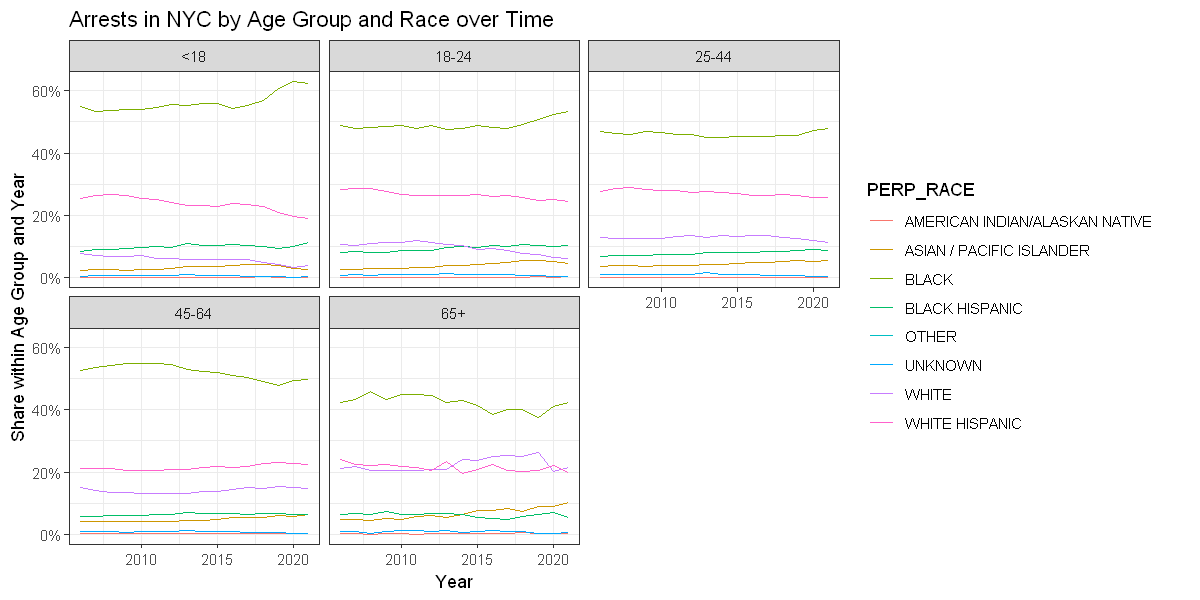

In [ ]:
data %>%
    add_count(AGE_GROUP, name = "age_count") %>%
    filter(age_count > 20) %>%
    mutate(year = lubridate::year(ARREST_DATE)) %>%
    count(year, AGE_GROUP, PERP_RACE) %>%
    group_by(year, AGE_GROUP) %>%
    mutate(n = n / sum(n)) %>%
    ggplot(aes(
        x = year,
        y = n,
        colour = PERP_RACE
    )) +
    geom_line() +
    facet_wrap(~AGE_GROUP) +
    labs(
        title = "Arrests in NYC by Age Group and Race over Time",
        y = "Share within Age Group and Year",
        x = "Year"
    ) +
    scale_y_continuous(labels = scales::percent_format())

### Map of occurences by crime type and perp race:

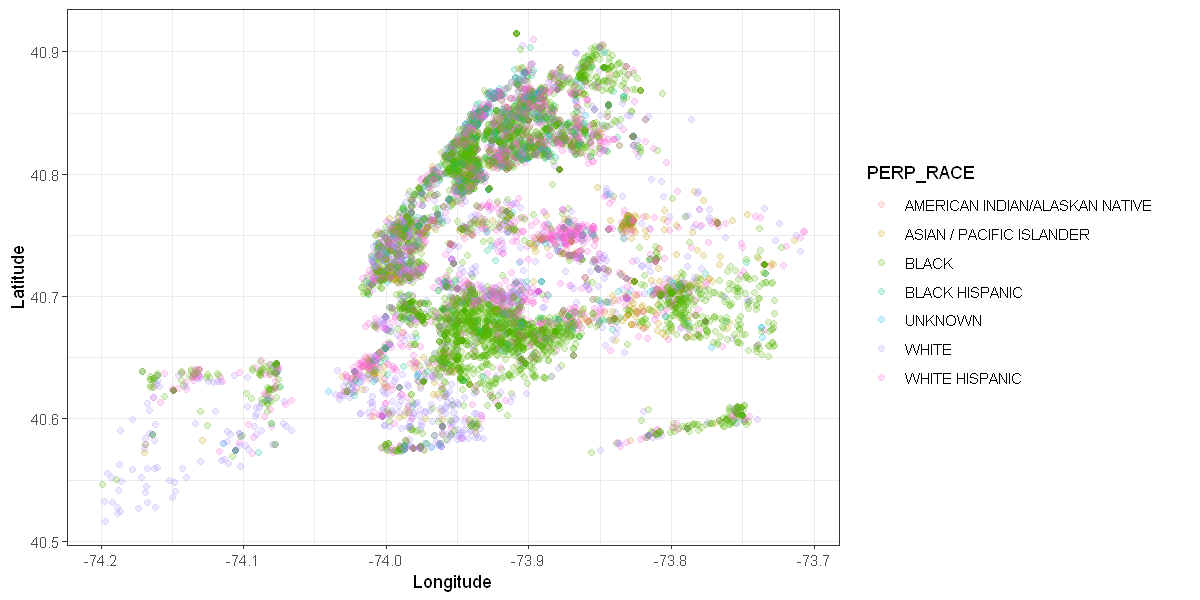

In [53]:
data %>% 
    filter(between(Latitude, 40.5, 41) & 
    between(Longitude, -74.2, -73.7)) %>% 
    sample_n(10000) %>% 
    select(OFNS_DESC, PERP_RACE, Latitude, Longitude) %>% 
    ggplot(aes(x = Longitude, y = Latitude)) +
    geom_point(aes(colour = PERP_RACE), alpha = 0.2)

In [23]:
glimpse(data)

Rows: 5,308,876
Columns: 19
$ ARREST_KEY        <dbl> 236791704, 237354740, 236081433, 32311380, 192799737…
$ ARREST_DATE       <date> 2021-11-22, 2021-12-04, 2021-11-09, 2007-06-18, 201…
$ PD_CD             <dbl> 581, 153, 681, 511, 177, NA, 579, 263, 729, 153, 101…
$ PD_DESC           <chr> NA, "RAPE 3", "CHILD, ENDANGERING WELFARE", "CONTROL…
$ KY_CD             <dbl> NA, 104, 233, 235, 116, NA, NA, 114, 113, 104, 344, …
$ OFNS_DESC         <chr> NA, "RAPE", "SEX CRIMES", "DANGEROUS DRUGS", "SEX CR…
$ LAW_CODE          <chr> "PL 2225001", "PL 1302502", "PL 2601001", "PL 220030…
$ LAW_CAT_CD        <chr> "M", "F", "M", "M", "F", "F", "F", "F", "F", "F", "M…
$ ARREST_BORO       <chr> "M", "B", "Q", "Q", "M", "M", "Q", "B", "Q", "K", "K…
$ ARREST_PRECINCT   <dbl> 28, 41, 113, 27, 25, 14, 115, 41, 113, 67, 83, 23, 3…
$ JURISDICTION_CODE <dbl> 0, 0, 0, 1, 0, 0, 0, 72, 0, 0, 0, 0, 0, 0, 2, 0, 0, …
$ AGE_GROUP         <chr> "45-64", "25-44", "25-44", "18-24", "45-64", "25-44"…
$ PERP_SEX  

### Development of selected crimes over time

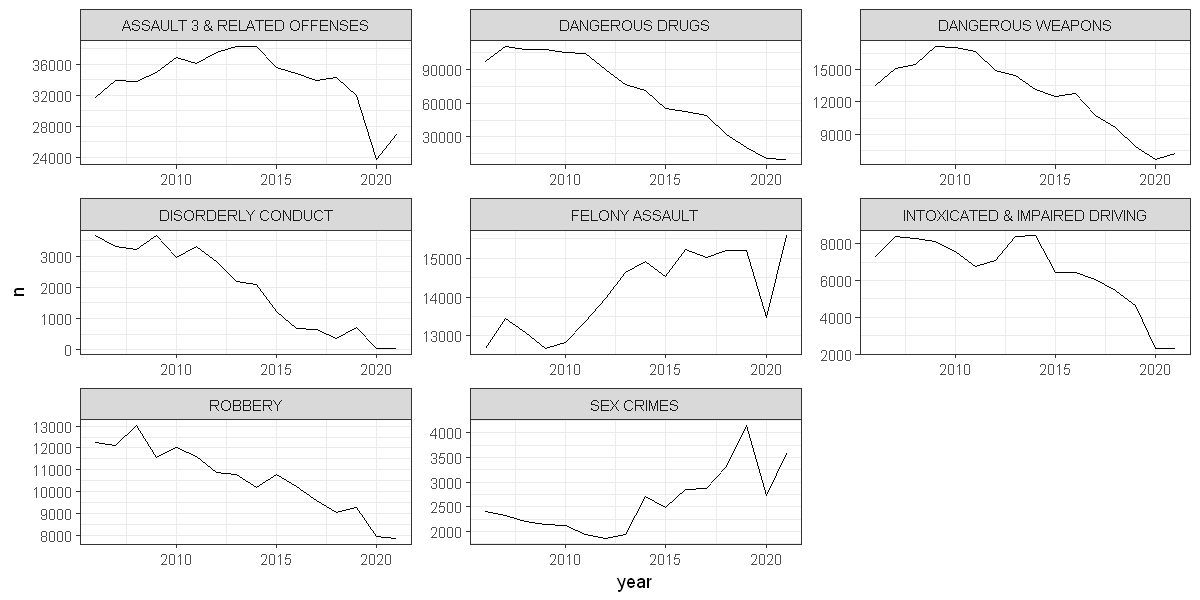

In [36]:
data %>% 
    filter(OFNS_DESC %in% c(
        "DANGEROUS DRUGS",
        "ASSAULT 3 & RELATED OFFENSES",
        "FELONY ASSAULT",
        "DANGEROUS WEAPONS",
        "ROBBERY",
        "INTOXICATED & IMPAIRED DRIVING",
        "SEX CRIMES",
        "DISORDERLY CONDUCT"
    )) %>% 
    mutate(year = lubridate::year(ARREST_DATE)) %>% 
    count(year, OFNS_DESC) %>% 
    ggplot(aes(x = year, y = n)) +
    geom_line() +
    facet_wrap(~ OFNS_DESC, scales = "free")

### Which demographics are part of which of these crimes?

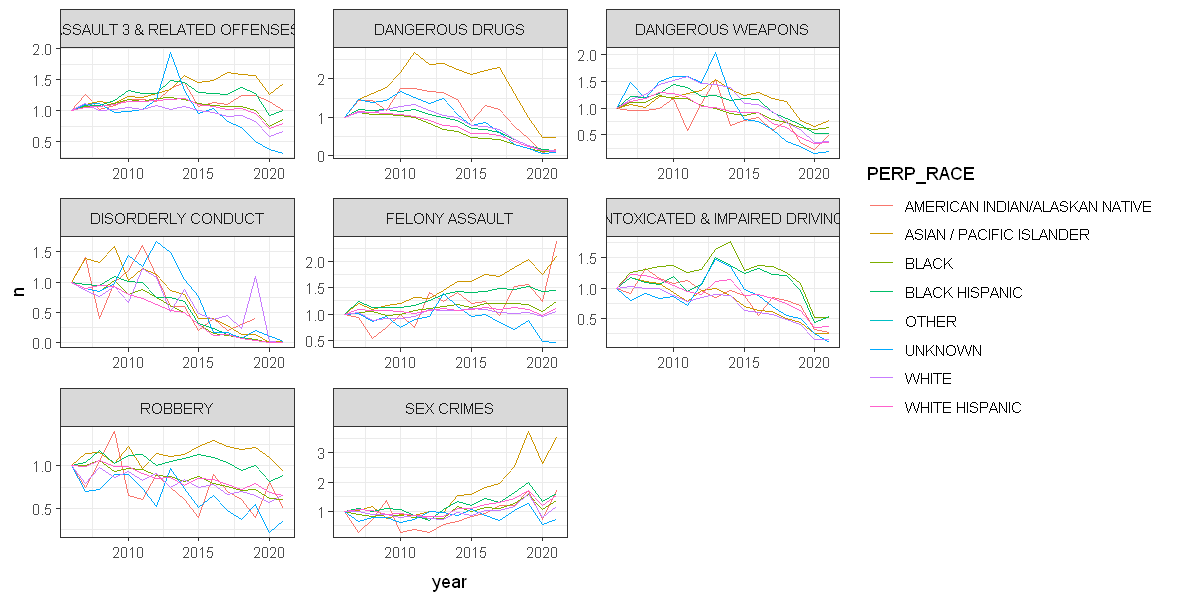

In [60]:
data %>% 
    filter(OFNS_DESC %in% c(
        "DANGEROUS DRUGS",
        "ASSAULT 3 & RELATED OFFENSES",
        "FELONY ASSAULT",
        "DANGEROUS WEAPONS",
        "ROBBERY",
        "INTOXICATED & IMPAIRED DRIVING",
        "SEX CRIMES",
        "DISORDERLY CONDUCT"
    )) %>% 
    mutate(year = lubridate::year(ARREST_DATE)) %>% 
    count(year, OFNS_DESC, PERP_RACE) %>% 
    group_by(PERP_RACE, OFNS_DESC) %>% 
    mutate(n = n/first(n)) %>% 
    ggplot(aes(x = year, y = n, colour = PERP_RACE)) +
    geom_line() +
    facet_wrap(~ OFNS_DESC, scales = "free")

### Steepest salary increase within agency

In [39]:
data <- read_csv("C:/Users/mathi/Downloads/NYC Citywide Pay Roll/Citywide_Payroll_Data__Fiscal_Year_.csv") %>%
    janitor::clean_names()

Rows: 5109775 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): Agency Name, Last Name, First Name, Mid Init, Agency Start Date, Wo...
dbl (8): Fiscal Year, Payroll Number, Base Salary, Regular Hours, Regular Gr...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [40]:
glimpse(data)

Rows: 5,109,775
Columns: 17
$ fiscal_year                <dbl> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2…
$ payroll_number             <dbl> 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,…
$ agency_name                <chr> "OFFICE OF EMERGENCY MANAGEMENT", "OFFICE O…
$ last_name                  <chr> "BEREZIN", "GEAGER", "RAMANI", "ROTTA", "WI…
$ first_name                 <chr> "MIKHAIL", "VERONICA", "SHRADDHA", "JONATHA…
$ mid_init                   <chr> NA, "M", NA, "D", "P", "A", NA, "N", "S", N…
$ agency_start_date          <chr> "08/10/2015", "09/12/2016", "02/22/2016", "…
$ work_location_borough      <chr> "BROOKLYN", "BROOKLYN", "BROOKLYN", "BROOKL…
$ title_description          <chr> "EMERGENCY PREPAREDNESS MANAGER", "EMERGENC…
$ leave_status_as_of_june_30 <chr> "ACTIVE", "ACTIVE", "ACTIVE", "ACTIVE", "AC…
$ base_salary                <dbl> 86005, 86005, 86005, 86005, 86005, 86005, 9…
$ pay_basis                  <chr> "per Annum", "per Annum", "per Annum", "per…
$ regular_ho

In [52]:
data %>%
    filter(pay_basis == "per Annum") %>%
    mutate(total_compensation = base_salary + total_ot_paid + total_other_pay) %>%
    group_by(agency_name, fiscal_year) %>%
    summarise(
        comp = median(total_compensation),
        n = n()
    )  %>% 
    filter(n > 30*6) %>% 
    ungroup() %>%
    arrange(agency_name, fiscal_year) %>%
    group_by(agency_name) %>%
    summarise(change = last(comp) / first(comp) - 1) %>%
    arrange(-change)

`summarise()` has grouped output by 'agency_name'. You can override using the
`.groups` argument.


agency_name,change
<chr>,<dbl>
HUNTER COLLEGE HIGH SCHOOL,0.4632584
CITY COUNCIL,0.4597964
CIVILIAN COMPLAINT REVIEW BD,0.4297005
OFFICE OF THE MAYOR,0.4194693
DEPT OF ED PEDAGOGICAL,0.3943114
COMMUNITY COLLEGE (KINGSBORO),0.3922615
ADMIN TRIALS AND HEARINGS,0.3890803
COMMUNITY COLLEGE (BRONX),0.3814975
COMMUNITY COLLEGE (HOSTOS),0.3756631


## NYC Dogs

In [5]:
data <- read_csv("C:/Users/mathi/Downloads/NYC Dogs/NYC_Dog_Licensing_Dataset.csv") %>%
    janitor::clean_names()

Rows: 508196 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): AnimalName, AnimalGender, BreedName, LicenseIssuedDate, LicenseExpi...
dbl (3): AnimalBirthYear, ZipCode, Extract Year

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Which breeds are how old?

In [7]:
data %>% glimpse()

Rows: 508,196
Columns: 8
$ animal_name          <chr> "PAIGE", "YOGI", "ALI", "QUEEN", "LOLA", "IAN", "…
$ animal_gender        <chr> "F", "M", "M", "F", "F", "M", "M", "F", "F", "M",…
$ animal_birth_year    <dbl> 2014, 2010, 2014, 2013, 2009, 2006, 2008, 2012, 2…
$ breed_name           <chr> "American Pit Bull Mix / Pit Bull Mix", "Boxer", …
$ zip_code             <dbl> 10035, 10465, 10013, 10013, 10028, 10013, 10025, …
$ license_issued_date  <chr> "09/12/2014", "09/12/2014", "09/12/2014", "09/12/…
$ license_expired_date <chr> "09/12/2017", "10/02/2017", "09/12/2019", "09/12/…
$ extract_year         <dbl> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2…


In [11]:
breeds <- data %>%
    count(breed_name, sort = T) %>%
    head(20) %>%
    pull(breed_name)

### Are there changes in popularity of breed over time?

In [21]:
data %>% 
    filter(breed_name %in% breeds) %>% 
    count(breed_name, extract_year) %>% 
    ungroup() %>% 
    arrange(breed_name, extract_year) %>% 
    group_by(breed_name) %>% 
    mutate(n = n/max(n))


breed_name,extract_year,n
<chr>,<dbl>,<dbl>
American Pit Bull Mix / Pit Bull Mix,2016,0.5716087
American Pit Bull Mix / Pit Bull Mix,2017,0.4055125
American Pit Bull Mix / Pit Bull Mix,2018,0.3334534
American Pit Bull Mix / Pit Bull Mix,2022,1.0000000
American Pit Bull Terrier/Pit Bull,2016,0.7751196
American Pit Bull Terrier/Pit Bull,2017,0.4107278
American Pit Bull Terrier/Pit Bull,2018,0.3256107
American Pit Bull Terrier/Pit Bull,2022,1.0000000
Beagle,2016,0.5741501
